# Urban Sound Classification - UrbanSound8K Dataset
## 8732 labeled sound excerpts
This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: <br>
air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. <br>
All audiofiles are in WAV format. <br>
After showing the audio for each class as wave and spectograms, we extract the features using Mel-frequency cepstral coefficients (MFCCs), that captures the spectral characteristics of an audio signal. After Scaling and Encoding our X and , we split into train and test data, where we can try different Classifier.

For more information about the dataset use the following Kaggle link:<br>
https://www.kaggle.com/datasets/chrisfilo/urbansound8k

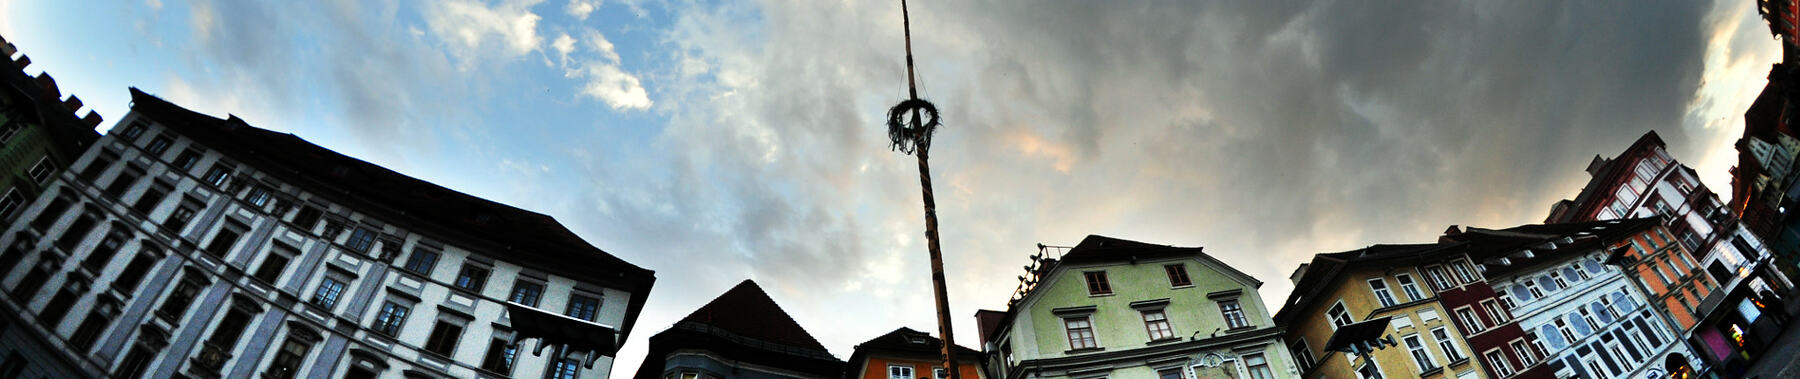

## Import Libraries and Load Data

In [1]:
#import libraries
import pandas as pd
import os
import csv
import librosa
import librosa.display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
le = LabelEncoder()

## EDA - Exploratory Data Analysis

In [2]:
# load csv
df = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
df.head() # first 5 entries

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
df.info() # infos about the samples, features and datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


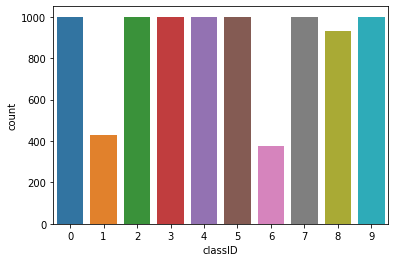

In [4]:
sns.countplot(x=df.classID); # show distribution of classes

We have a total of 8732 samples, and an almost even distribution of the 10 classes.

## Loading the Audio Files
With the load function of Librosa we are loading all of the audio files in our dataset and we store the audio files and labels in lists. so we can use them later for feature extracting and modeling.

In [5]:
# Load the audio files and labels
audio_files = []
labels = []

# Load the labels from the csv file
label_dict = {}
with open("/kaggle/input/urbansound8k/UrbanSound8K.csv") as f:
    reader = csv.reader(f)
    next(reader)  # skip header row
    for row in reader:
        filename = row[0]
        label = row[7]  # label is in the 8th column (index 7)
        label_dict[filename] = label

# Loop through all the folders in the directory
for foldername in os.listdir("/kaggle/input/urbansound8k/"):
    if foldername.endswith(".csv"):  # skip csv files
        continue
    # Loop through all the audio files in the folder
    for filename in os.listdir("/kaggle/input/urbansound8k/{}".format(foldername)):
        # Load the audio file
        data, sr = librosa.load("/kaggle/input/urbansound8k/{}/{}".format(foldername, filename), sr=None)
        
        # Get the label for the audio file
        label = label_dict[filename]
        
        audio_files.append((data, sr))
        labels.append(label)

## Listen to the Audio Files
With IPyhton we can play the Audio file directly in a Jupyter notebook.

In [17]:
import IPython
from IPython.display import Audio
# Loop through all the classes
for category in set(labels):
    # Find an audio file in the category
    index = labels.index(category)
    data, sr = audio_files[index]
    
    # Play the audio file
    print("Playing example audio file for category: {}".format(category))
    IPython.display.Audio(data=data, rate=sr)

Playing example audio file for category: siren
Playing example audio file for category: car_horn
Playing example audio file for category: gun_shot
Playing example audio file for category: street_music
Playing example audio file for category: dog_bark
Playing example audio file for category: jackhammer
Playing example audio file for category: drilling
Playing example audio file for category: air_conditioner
Playing example audio file for category: engine_idling
Playing example audio file for category: children_playing


In [24]:
# play an Audio Sample
data_ex, sr_ex = audio_files[0]
IPython.display.Audio(data=data_ex, rate=sr_ex)

Here we can clearly here Sirens.

## Audio Visualization - Wave & Spectogram
We show for each category one audio sample as a wave and a spectogram to have a better insight of the classes and the differences.

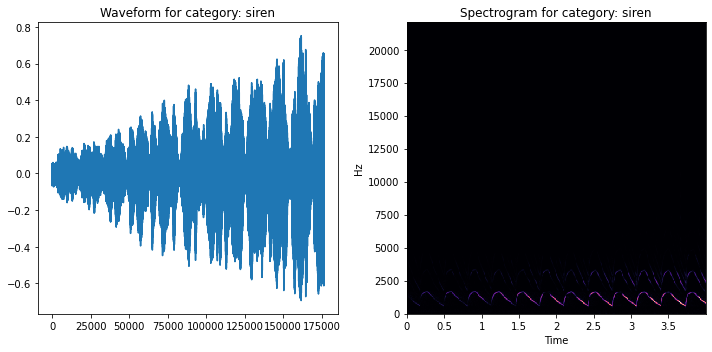

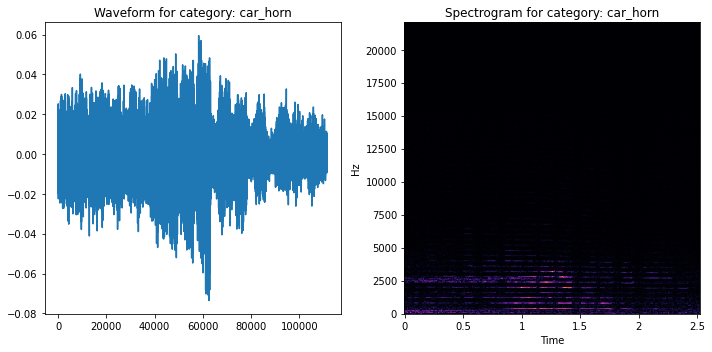

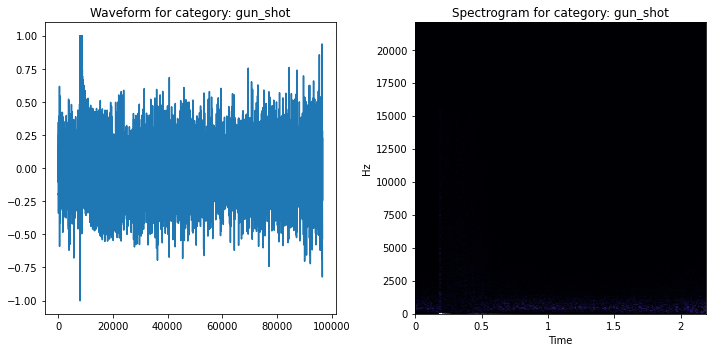

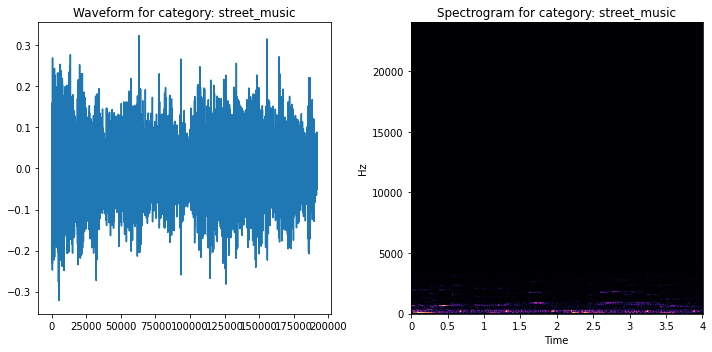

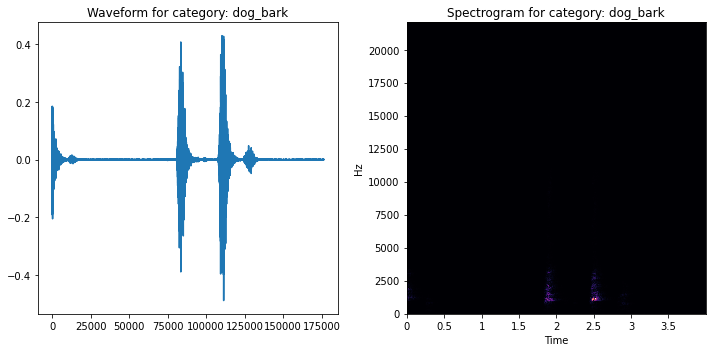

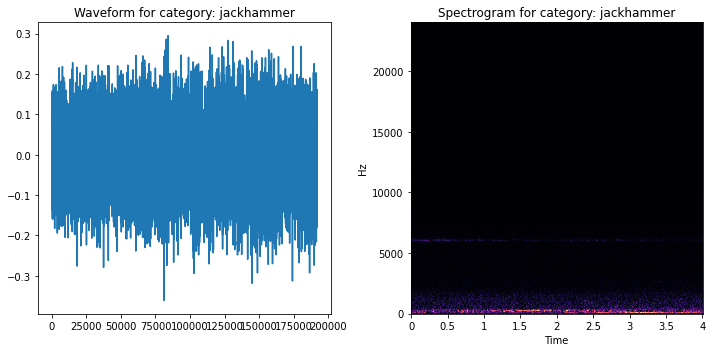

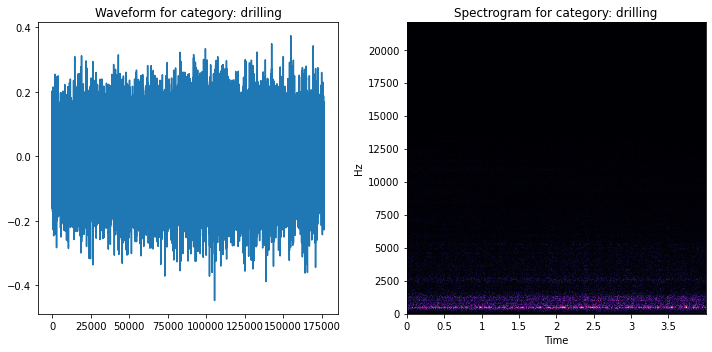

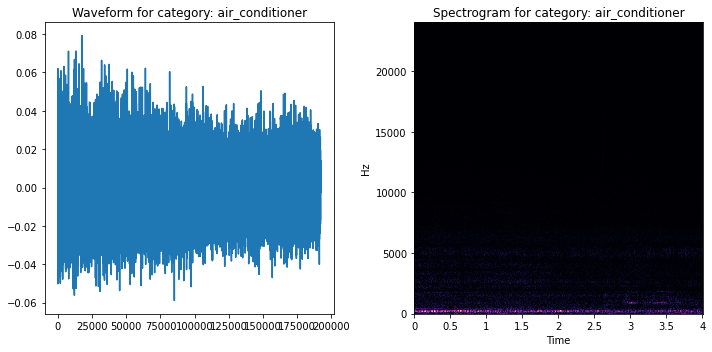

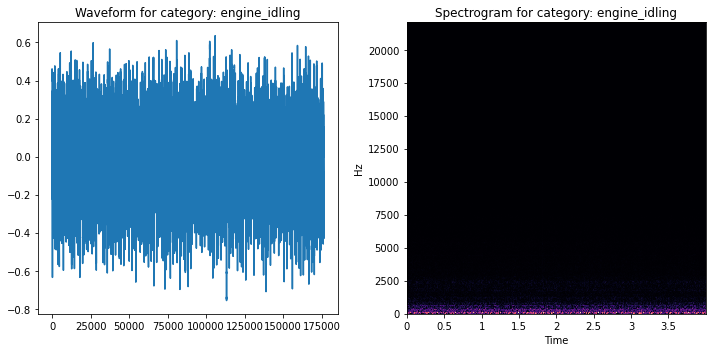

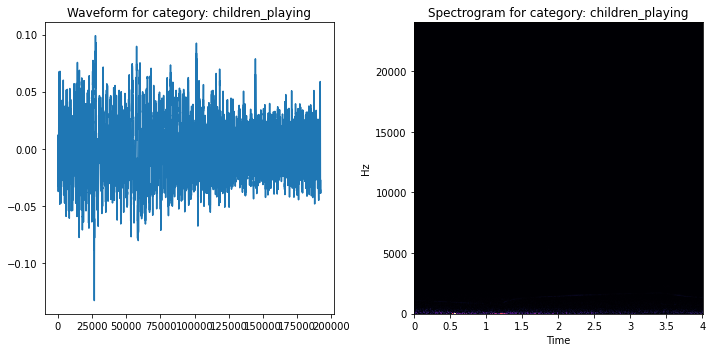

In [6]:
# Loop through all the categories
for category in set(labels):
    # Find an audio file in the category
    index = labels.index(category)
    data, sr = audio_files[index]
    
    # Plot the waveform and spectrogram in the same figure
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax1.plot(data)
    ax1.set_title("Waveform for category: {}".format(category))
    S = librosa.core.stft(data, n_fft=1024, hop_length=512)
    spectrogram = np.abs(S)
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='linear', ax=ax2)
    ax2.set_title("Spectrogram for category: {}".format(category))
    fig.tight_layout()
    plt.show()

We can see the differences of each class in the waveform of the audio files. To be honest I don't know if the spectograms are correct as shown here, I am new to Audio Data Processing but I think it should be right.

## Feature Extracting - MFCCs
**Mel-frequency cepstral coefficients (MFCCs)** are a set of features that capture the spectral characteristics of an audio signal. They are commonly used in speech and music processing. MFCCs are typically used to represent the spectral envelope of an audio signal, which is a summary of the spectral content of the signal over time. They are useful for tasks such as speaker recognition, speech recognition, and music classification, as they capture the spectral characteristics of the signal that are relevant to these tasks.

In [7]:
X = []
max_length = 0
for data, sr in audio_files:
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T,axis=0)
    X.append(mfccs_scaled)

/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


## Getting X and y ready
After Scaling the mfccs and using the label encoder on our labels, we can split our data into train and test datas.

In [8]:
# Scale X and One-Hot Encoding for y
X = scaler.fit_transform(X)
y = labels
y = le.fit_transform(labels)

In [9]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

In [12]:
# import Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define the classifiers to use
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    SGDClassifier(),
    MLPClassifier(),
    XGBClassifier()
]

# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall'])

# Loop through the classifiers
for clf in classifiers:
    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    # Evaluate the classifier on the test data
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    
    # Store the results in the DataFrame
    results = results.append({'Classifier': clf.__class__.__name__,
                              'Accuracy': accuracy,
                              'Precision': precision,
                              'Recall': recall},
                             ignore_index=True)

# Sort the DataFrame by the Accuracy column in descending order
results.sort_values(by='Accuracy', ascending=False, inplace=True)

# show the DataFrame
results

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Classifier,Accuracy,Precision,Recall
2,RandomForestClassifier,0.898111,0.912035,0.885043
7,XGBClassifier,0.896966,0.910150,0.887456
6,MLPClassifier,0.882656,0.885877,0.885259
0,KNeighborsClassifier,0.880939,0.891316,0.876484
4,GradientBoostingClassifier,0.808815,0.828554,0.800048
1,DecisionTreeClassifier,0.696623,0.684618,0.688498
5,SGDClassifier,0.499141,0.499938,0.477443
3,AdaBoostClassifier,0.381797,0.365335,0.381821


The best result shows the **RandomForestClassifier with an Accuracy of 89,81%, Precision Score of 91,20% and Recall Score of 88,50%**, followed by the XBGClassifier.

Again ChatGpt was very helpfull here again, for plotting the audios and some details.